In [31]:
# waveform sandbox 
waveform_data = {}
waveform_data["Header"]={}
waveform_data["Parameters"]={}
waveform_data["Data"]=[]
currSection = ""
with open("Waveform/ATS24/2401.wf") as f:
    data = f.readlines()
    for dline in data:
        sectionChanged = False
        # know the current section
        for sec in ["Header","Parameters","Data"]:
            if dline.find(sec) != -1:
                currSection = sec
                sectionChanged = True 
        if sectionChanged:
            continue 
            
        dline = dline.strip()
        if (currSection=="Header" or currSection=="Parameters") and len(dline)>1:
            keyval = dline.split("=")
            if keyval[1][0].isdigit():
                keyval[1] = float(keyval[1])
            waveform_data[currSection][keyval[0]] = keyval[1]
        elif currSection=="Data" and len(dline)>1:
            waveform_data[currSection].append(float(dline))
    

In [39]:
filepath = "../Waveform/ATS26/26%02d"%((49))
print filepath

../Waveform/ATS26/2649


In [40]:
str(waveform_data["Parameters"])

"{'FEV1FVC': 71.0, 'FEV1': 4.262, 'PEF': 6.497, 'FEF2575': 3.41, 'FVC': 6.0}"

In [6]:
from scikits.talkbox import lpc

In [7]:
import numpy as np
np.__version__

'1.10.4'

In [1]:
import scipy.io.wavfile as wavfile
from scipy.signal import *
from scipy import optimize
import sys
from matplotlib.pyplot import specgram
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
fs, x = wavfile.read("audio_curve_data/1458068326.957989.wav")

/Library/Python/2.7/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


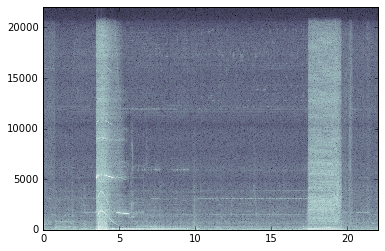

In [2]:
P_skip = 128
P_NFFT = 2048
P,P_f,P_t,im = specgram(x, NFFT=P_NFFT, Fs=fs, noverlap=P_NFFT-P_skip)
P = P.astype(np.float)
durationOfRecording = P_t[-1]

plt.pcolormesh(P_t, P_f, 10 * np.log10(P),cmap=plt.cm.bone)

In [66]:
X_inv = .5*np.array([
    [1, -2, 1],
    [-1, 0, 1],
    #[0, 2, 0]
])

def cubic_peak_interpolation(P_slice):
    # Get the peak index
    peak_idx = min(max(np.argmax(P_slice),1), len(P_slice)-2)

    # Now perform cubic interpolation to get sub-bin accuracy (we assume the peak is never the first or last index)
    Z = np.dot(X_inv, P_slice[peak_idx-1:peak_idx+2])

    # We now have the a and b coefficients of the parabola (we disregard c), so we find peak offset
    # and use that to get sub-bin accuracy:
    return peak_idx - Z[1]/(2*Z[0])

# Weigh lower frequencies better
def decreasing_windowed_fft_analysis(P, sigma=10.0, lowweight=.9, fs=2):
    max_idx = np.unravel_index(np.argmax(P), P.shape)

    # Step forward and backward
    fft_f = np.zeros((P.shape[1],))
    fft_f[max_idx[1]] = max_idx[0]
    for t in xrange(max_idx[1]+1, P.shape[1]):
        # Build an appropriate window centered on fft_f[t-1]
        window = np.exp(-(fft_f[t-1]*lowweight - np.arange(P.shape[0]))**2/sigma**2)

        fft_f[t] = cubic_peak_interpolation(P[:,t]*window)

    for t in xrange(max_idx[1]-1, 0, -1):
        # Build an appropriate window centered on fft_f[t+1]
        window = np.exp(-(fft_f[t+1]*lowweight - np.arange(P.shape[0]))**2/sigma**2)

        fft_f[t] = cubic_peak_interpolation(P[:,t]*window)

    return fft_f*fs/(2*P.shape[0])

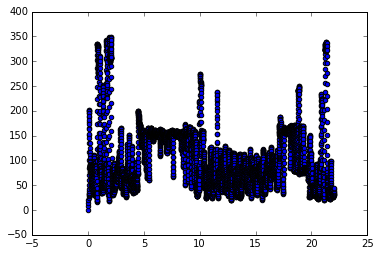

In [67]:
P_max = decreasing_windowed_fft_analysis(P[:70,:], fs=fs)*70/P.shape[0]
b, a = butter(3, .1, btype='low')
P_max = filtfilt(b, a, P_max)

P_argmax = np.int_(P_max*P_NFFT/fs)
P_weights = np.array([P[P_argmax[t],t] for t in xrange(P.shape[1])])**2
plt.scatter(P_t, P_max)

1227


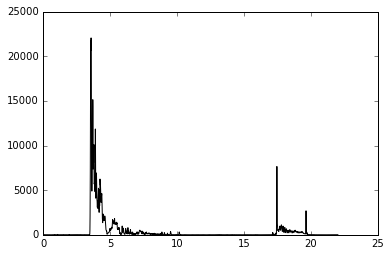

In [3]:
# Find the section of the signal we're interested in by just looking at the energy. Yay Parseval's Theorem!
energy = np.sum(P, axis=0)
energy = energy*(fs/2)/np.max(energy)
plt.plot(P_t, energy, 'k')
PEF_index = np.argmax(energy)
print PEF_index

In [47]:
# Find peak temporal energy, find peak frequency within 0.X seconds from that peak
tpeak_idx = np.argmax(energy)
tpeak_left = max((tpeak_idx-80,0))
tpeak_right = min((tpeak_idx+80,P.shape[1]))
peak_idx = np.argmax(P_max[tpeak_left:tpeak_right]) + tpeak_left
PEF = P_max[peak_idx]
PEF

151.20842793701917

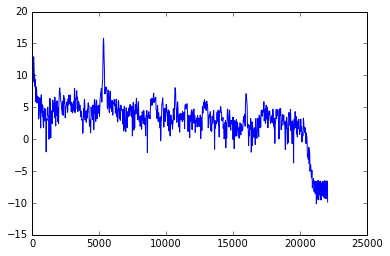

In [79]:
PEF_fft_frame = P[:,PEF_index]
plt.plot(P_f,np.log(PEF_fft_frame))

In [6]:
from skimage import morphology as mp

In [7]:
P_normalized = np.log(P)
P_normalized = (P_normalized - np.min(P_normalized)) / (np.max(P_normalized)-np.min(P_normalized))*255
P_normalized = P_normalized.astype(np.uint8)
P_dilate = mp.dilation(P_normalized,np.matrix(np.ones((40,1))).astype(np.uint8))

# P_local_max = mp.binary_dilation(P_dilate==P_normalized,mp.disk(1)) & (P_normalized>190)
mask = np.repeat((energy>np.mean(energy)*0.1),P.shape[0], axis=0).reshape(P.T.shape).T
mask = mp.binary_closing(mask,np.ones((1,50)))
mask = mp.binary_erosion(mask,np.ones((1,50)))
P_local_max = (P_dilate==P_normalized) & (P_normalized>170) & mask

P_local_max = mp.binary_closing(P_local_max,np.eye(3))
P_local_max = mp.binary_closing(P_local_max,np.eye(3).T)
#P_local_max = mp.skeletonize(P_local_max)
P_local_max = P_local_max.astype(np.bool)
P_local_max = mp.remove_small_objects(P_local_max, min_size = 50, connectivity=13, in_place=True)


In [8]:
plt.figure(figsize=(10,10))
# P_local_max = mp.binary_dilation(P_local_max,mp.disk(2))
Ptmp = P_normalized.copy()
Ptmp[P_local_max==True] = 0
plt.pcolormesh(P_t, P_f, Ptmp, cmap=plt.cm.bone)
plt.show()

AttributeError: 'module' object has no attribute 'pcolorfast'

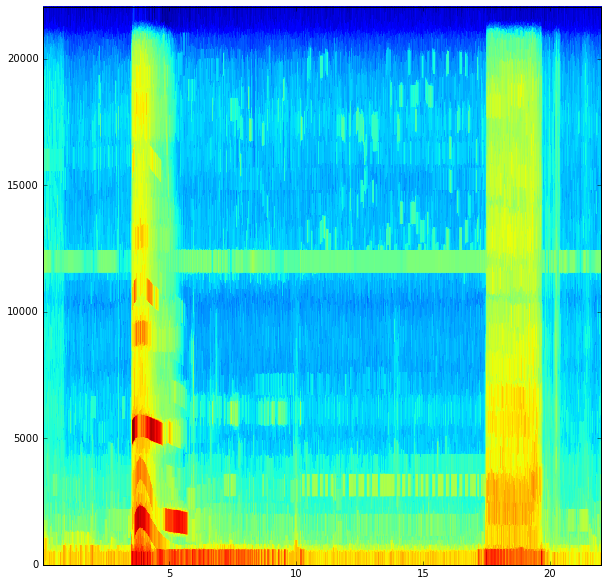

In [9]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.pcolorfast(P_t, P_f, P_dilate)
plt.show()

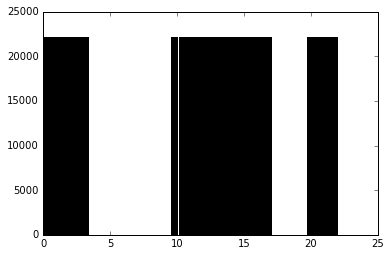

In [291]:
mask = np.repeat((energy>np.mean(energy)*0.1),P.shape[0], axis=0).reshape(P.T.shape).T
mask = mp.binary_closing(mask,np.ones((1,100)))
plt.pcolormesh(P_t, P_f, mask,cmap=plt.cm.bone)


In [323]:
def create_custom_wf(PEF,name):

    import numpy as np
    from matplotlib import pyplot as plt
    %matplotlib inline

    fs = 100
    with open('%s.wf'%(name),'w') as f:
        f.write('[Header]\n')
        f.write('Group=OpenSpiro\nName=%s\nType=FT\nFreq=%d\nExpStart=0\n\n'%((name,fs)))
        
        FVC = 20
        numpoints = 1000
        while FVC > 9.9999:
            numpoints = numpoints-5
            data = np.linspace(0,PEF,numpoints)
            data = np.hstack((data,np.ones((int(fs/5)))*PEF,data[::-1]))
            FVC = np.sum(data/float(fs))

        f.write('[Parameters]\nPEF=%.4f\nFVC=%.4f\n\n[Data]\n'%((PEF,FVC)))
        for num in data:
            f.write('%.4f\n'%(num))

    print PEF, FVC, len(data)/float(fs)
    plt.plot(np.array(range(len(data)))/float(fs),data)
    plt.show()

1.0 9.95 19.7


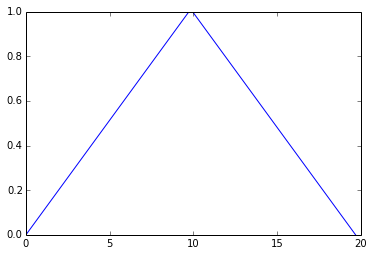

2.0 9.9 9.7


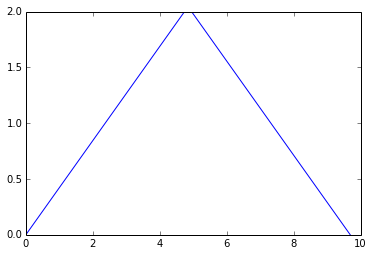

3.0 9.9 6.4


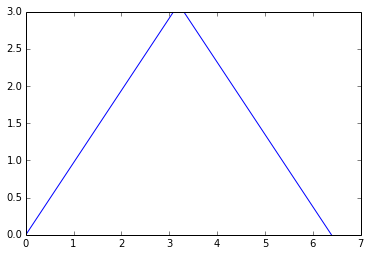

4.0 9.8 4.7


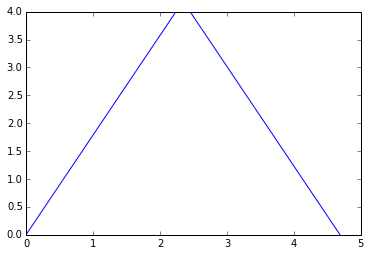

5.0 9.75 3.7


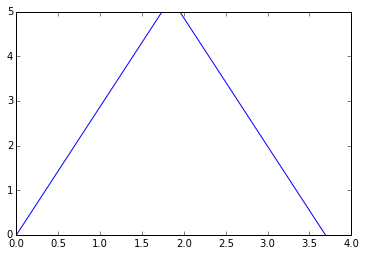

6.0 9.9 3.1


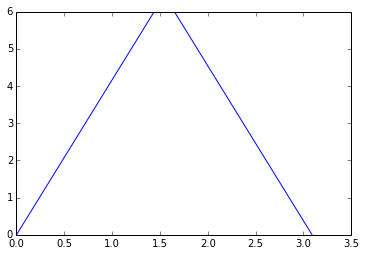

7.0 9.8 2.6


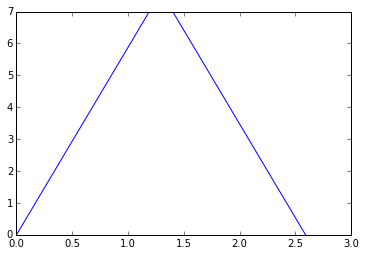

8.0 9.6 2.2


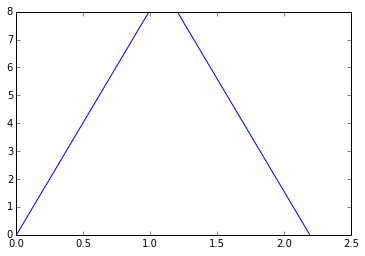

9.0 9.9 2.0


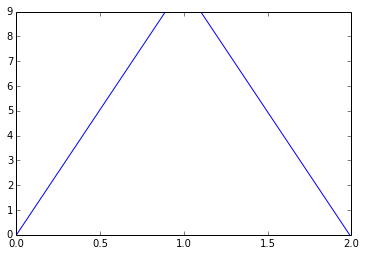

10.0 9.5 1.7


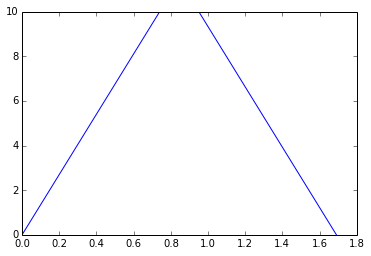

11.0 9.9 1.6


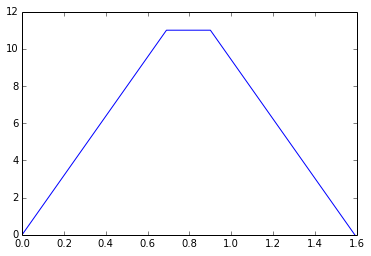

In [324]:
for i,PEF in enumerate([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0]):
    create_custom_wf(PEF,'Custom%02d'%(i+6))

In [315]:
def create_custom_wf_rise(data,name):
    import numpy as np
    from matplotlib import pyplot as plt
    %matplotlib inline
    
    PEF = data[0]
    rise = data[1]
    fs = 200
    with open('%s.wf'%(name),'w') as f:
        f.write('[Header]\n')
        f.write('Group=OpenSpiro\nName=%s\nType=FT\nFreq=%d\nExpStart=0\n\n'%((name,fs)))
        
        FVC = 20
        numpoints = 500
        while FVC >= 10:
            numpoints = numpoints-5
            data = np.linspace(0,PEF,int(PEF/rise*fs) + 1)
            data = np.hstack((data,np.ones((numpoints))*PEF,data[::-1]))
            FVC = np.sum(data/float(fs))
            
        f.write('[Parameters]\nPEF=%.4f\nFVC=%.4f\n\n[Data]\n'%((PEF,FVC)))
        for num in data:
            f.write('%.4f\n'%(num))
    print PEF, FVC, len(data)/float(fs)
    plt.plot(np.array(range(len(data)))/float(fs),data)
    plt.show()

5.0 9.925 2.045


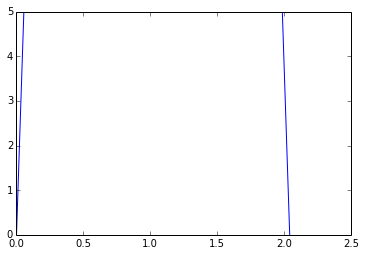

5.0 9.875 2.05


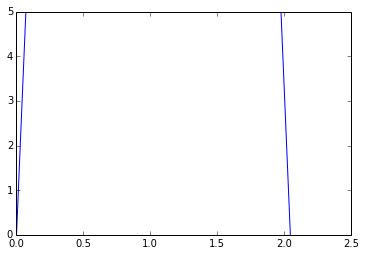

5.0 9.9 2.085


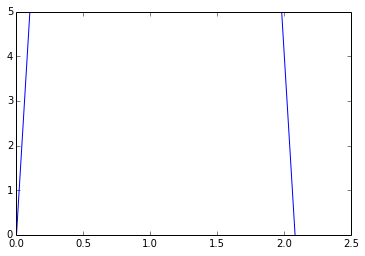

5.0 9.975 2.165


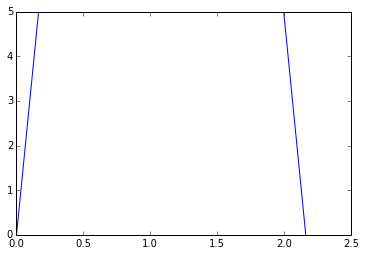

5.0 9.9 2.485


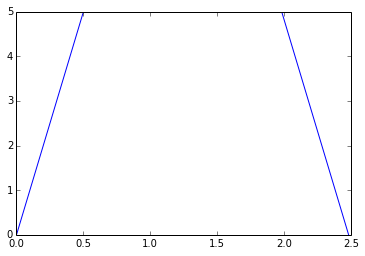

In [316]:
for i,data in enumerate([(5.0,90.0),(5.0,70.0),(5.0,50.0),(5.0,30.0),(5.0,10.0)]):
    create_custom_wf_rise(data,'Custom%02d'%(i+1))